# Exploração Inicial

In [1]:
import numpy as np
import pandas as pd
import missingno as msno
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('desafio.csv')
df.head()

,order_id,code,quantity,price,pis_cofins,icms,tax_substitution,category,liquid_cost,order_status,capture_date,process_date,process_status,source_channel
0,bcb59c839e78b2601374cbad9239ca7b,e6762ba2ffbca07ab6cee7551caeaad5,1,978.90,90.5483,0.0000,191.8416,4ece547755cba9e7fc14125bc895f31b,542.7065,entrega total,2016-06-11,2016-06-11,processado,b76eb9b8fc0f17098812da9117d3e500
1,4e91ee6b95895771dc9ee524e910a902,e6762ba2ffbca07ab6cee7551caeaad5,1,1036.29,95.8568,176.1693,0.0000,4ece547755cba9e7fc14125bc895f31b,542.7065,em rota de entrega,2016-06-11,2016-06-11,processado,b76eb9b8fc0f17098812da9117d3e500
2,88eb0ac86af1a521c0831298d22dea8b,e6762ba2ffbca07ab6cee7551caeaad5,1,978.90,90.5483,0.0000,191.8416,4ece547755cba9e7fc14125bc895f31b,542.7065,entrega total,2016-06-12,2016-06-12,processado,b76eb9b8fc0f17098812da9117d3e500
3,dee418152a36314b4aee6ce9cf94fcbf,e6762ba2ffbca07ab6cee7551caeaad5,1,978.90,90.5483,176.2020,0.0000,4ece547755cba9e7fc14125bc895f31b,542.7065,cancelado,2016-06-13,0000-00-00,captado,b76eb9b8fc0f17098812da9117d3e500
4,1c175bc61b9b659bbf011b2e5e3dcec6,e6762ba2ffbca07ab6cee7551caeaad5,1,976.05,90.2846,0.0000,192.3325,4ece547755cba9e7fc14125bc895f31b,542.7065,entrega total,2016-06-13,2016-06-13,processado,b76eb9b8fc0f17098812da9117d3e500


### Linhas e Colunas

In [3]:
# Taking a look at how many rows and columns the dataset contains
rows = df.shape[0]
columns = df.shape[1]
print("The train dataset contains {0} rows and {1} columns".format(rows, columns))

The train dataset contains 179149 rows and 14 columns


### Verificando ausência de dados

In [4]:
# any() applied twice to check run the isnull check across all columns.
print('Algum dado nulo?', df.isnull().any().any())

('Algum dado nulo?', False)


### Visualizando zeros nas colunas númericas

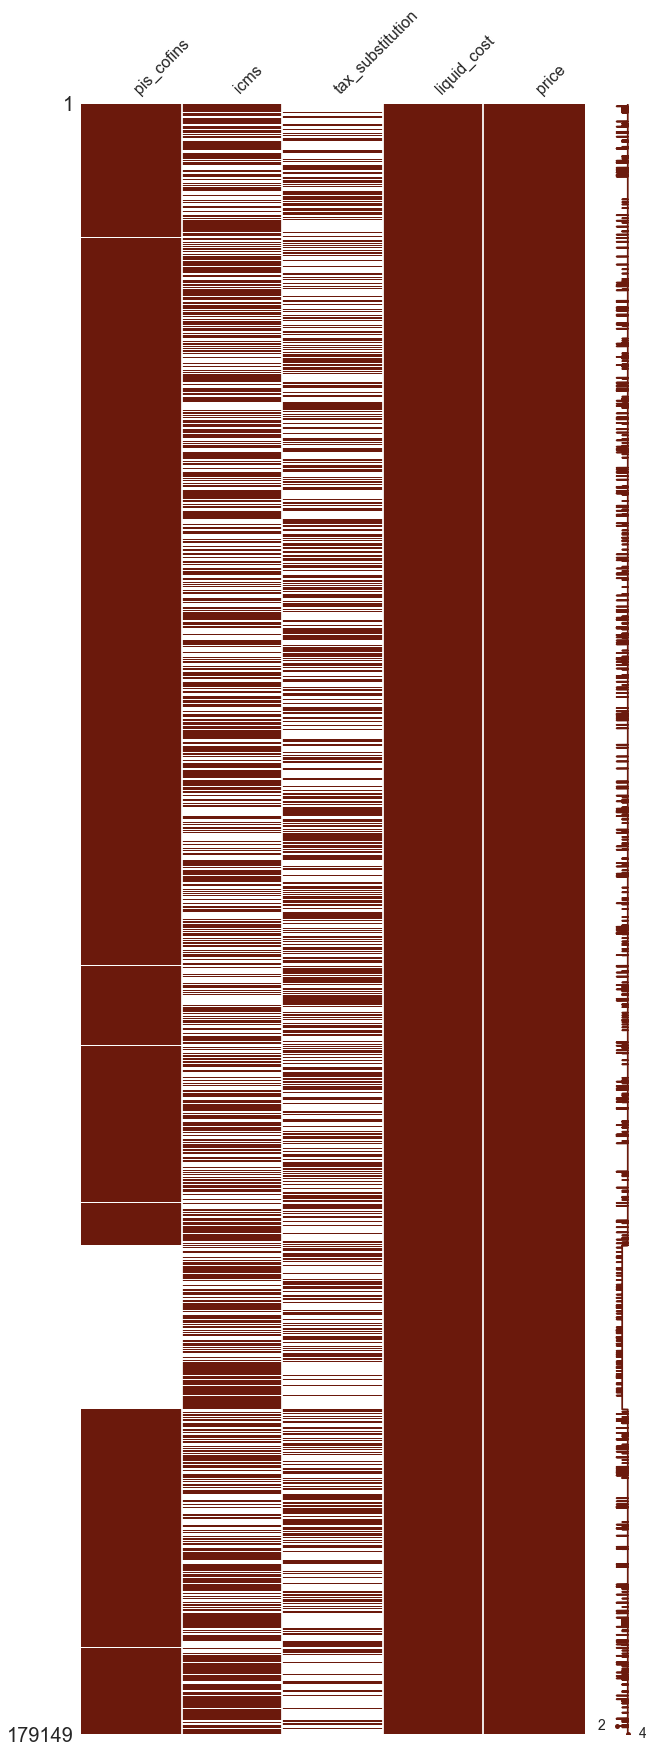

In [5]:
df_copy = df.copy()
df_copy = df_copy.replace(0, np.NaN)

number_columns = ['pis_cofins','icms', 'tax_substitution', 'liquid_cost', 'price']

# Nullity or missing values by columns
msno.matrix(df=df_copy.loc[:, number_columns], figsize=(10, 30), color=(0.42, 0.1, 0.05))

### Averiguando grupo de zeros

In [6]:
print(df.iloc[125454:143463, :].category.describe())
df[df['category'] == '9a97178a18aa6333aabdfb21de182b99'].pis_cofins.describe()

count                                18009
unique                                   1
top       9a97178a18aa6333aabdfb21de182b99
freq                                 18009
Name: category, dtype: object


count    18009.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: pis_cofins, dtype: float64

### Podemos notar um grande vazio na coluna de PIS/COFINS
- Uma sequência esquisita pois se dá exatamente na sequência entre os índices 125454 e 143463
- Todos os subitens com pis_cofins zerado são da categoria 9a97178a18aa6333aabdfb21de182b99. Como há produtos isentos deste imposto, assumiu-se que não é um erro.

### Notas e observações sobre os dados
- PIS/COFINS são de 0% ou aproximadamente 9,25%.
- Não há nenhuma cagegory isenta de ICMS
- Os valores mais comuns da alíquota de ICMS são 0% e 18%
- order_id são ordens de compra, com subitens. Cada subitem possui um code distinto.
- Uma ordem de compra é processada em sua totalidade. Caso não seja processada, todos os subitens ficarão como captados. Esta é a informação contida em process_status.
- Uma ordem de compra é tem os mesmos status da ordem em todos os seus subitens. Portanto, por exemplo, suspeita de fraude caí sobre todos os subitens. O mesmo é válido para entrega parcial, entrega total, etc. Esta é a informação contida em order_status.
- Uma ordem de compra tem apenas uma data de captura e uma data de processamento.
- Subitens designados por code tem variação de preço.
- As fórmulas para cálculo de lucro e margem são:
$$net\_price= gross\_price - pis\_cofins - icms$$
$$net\_margin= (net\_price - liquid\_cost) / gross\_price$$

$$gross\_cost= liquid\_cost + tax\_substitution$$
$$gross\_margin= (gross\_price - gross\_cost)/ gross\_price$$

- process_status e order_status se relacionam desta maneira:

```
-captado
      cancelado
      cancelado boleto não pago
      cancelado dados divergentes
      cancelado fraude confirmada
      cancelado não aprovado
      em rota de devolução
      fraude confirmada
      pendente processamento
      suspeita de fraude
      suspenso barragem
-processado
      disponível para retirada.
      em rota de entrega
      entrega parcial
      entrega total
      processado
      solicitação de cancelamento
      solicitação de troca
```

# Pré-Processamento
- Hipótese: Assume-se que o order_status não influencia no forecast de demanda. Portanto, não será considerado
- Para simplificação, não será levado em conta o process_status. Captado ou Processado, a demanda se realizou e, para fins de forecast, assume-se que isto não será relevante.

### Linhas com data de processamento devem ter o process_status como 'processado'

In [7]:
df[df.process_status == 'captado'][df.process_date != '0000-00-00'].process_status = 'processado'

/Users/raphaelrrcoelho/anaconda3/envs/luizalabs/lib/python2.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [8]:
df = df.drop(['order_status', 'process_status'], axis = 1)

### Convertendo capture_date em yearmon e dando drop no process_date
- Hipótese: Assume-se que o process_date não é relevante para forecast de demanda. capture_date deve cobrir a sazonalidade

In [9]:
capture_date = pd.to_datetime(df.capture_date, errors='coerce')

df['sale_yearmon'] = capture_date.map(lambda x: str(x.year) + '-' + str(x.month).zfill(2))
df['sale_year'] = capture_date.map(lambda x: str(x.year))
df['sale_month'] = capture_date.map(lambda x: str(x.month))
df['sale_day'] = capture_date.map(lambda x: str(x.day))

df=df.rename(columns = {'capture_date':'sale_date'})
df = df.drop(['process_date'], axis = 1)

### Adição de colunas relacionadas a margens e preço líquido

In [10]:
gross_cost = df['liquid_cost'] + df['tax_substitution']
gross_profit = df['price'] - gross_cost


net_price = df['price'] - df['pis_cofins'] - df['icms']
net_profit = net_price - df['liquid_cost']


df['gross_margin'] = gross_profit / df['price']
df['net_margin'] = net_profit / df['price']

df = df.drop(['liquid_cost'], axis = 1)

In [11]:
df.tail()

,order_id,code,quantity,price,pis_cofins,icms,tax_substitution,category,sale_date,source_channel,sale_yearmon,sale_year,sale_month,sale_day,gross_margin,net_margin
179144,3865248aaa3ddf5dca346f14caf8dcef,1c234775cae774823f38abe6721e61a4,2,891.21,82.4369,151.5057,0.0,388128822cef4b4f102ae881e040a64b,2017-05-30,fc7020775a7cdf161ab5267985c54601,2017-05,2017,5,30,0.754147,0.491647
179145,519c339baad17b8692a0c8bb86a45586,1c234775cae774823f38abe6721e61a4,1,449.40,41.5695,80.8920,0.0,388128822cef4b4f102ae881e040a64b,2017-05-31,b76eb9b8fc0f17098812da9117d3e500,2017-05,2017,5,31,0.512446,0.239946
179146,0f4d6b4a1750214b3fc782e3a6029939,1c234775cae774823f38abe6721e61a4,1,507.28,46.9234,91.3104,0.0,388128822cef4b4f102ae881e040a64b,2017-05-31,fc7020775a7cdf161ab5267985c54601,2017-05,2017,5,31,0.568076,0.295576
179147,1ace6be0122c83e55dcfa05e3484f0b2,1c234775cae774823f38abe6721e61a4,1,446.90,41.3383,75.9730,0.0,388128822cef4b4f102ae881e040a64b,2017-06-01,b76eb9b8fc0f17098812da9117d3e500,2017-06,2017,6,1,0.509719,0.247219
179148,3d47c183dd47f21879031cc2814206b0,1c234775cae774823f38abe6721e61a4,1,507.28,46.9234,91.3104,0.0,388128822cef4b4f102ae881e040a64b,2017-06-01,fc7020775a7cdf161ab5267985c54601,2017-06,2017,6,1,0.568076,0.295576


In [12]:
df.to_csv('preprocessed.csv', index=False)